In [1]:
knitr::opts_chunk$set(echo = TRUE)
library(dplyr)
library(data.table)
library(tidyr)
library(gam)
library(gratia)
library(cluster)
library(factoextra)
library(mgcv)
library(sjPlot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-34. For overview type 'help("mgcv-package")'.


Attaching package: ‘mgcv’


The following objects are masked from ‘package:gam’:

    gam, gam.control, gam.fit, s




In [6]:
df_long <- fread('Lifespan_Components_tall_nonan.csv')


In [37]:
Fit_Models<-function(x){

  #gam_model<-gam(value~s(Age,k=8),data=x)
   gam_model<-gam(exp~s(logAge,k=7),data=x)
    
  # get the sig ages from the derivative
  #derv<-derivatives(gam_model,term='Age')
    derv<-derivatives(gam_model,term='logAge')
  derv<- derv %>%
    mutate(sig = !(0 >lower & 0 < upper))
  derv$sig_deriv = derv$derivative*derv$sig
  if (all(derv$sig==FALSE)){
    minAgeEst=0; maxAgeEst=0
  } else {
    minAgeEst<-min(derv$data[derv$sig==T])
    maxAgeEst<-max(derv$data[derv$sig==T])
  }
  #smooth_est = smooth_estimates(gam_model,"s(Age)",n=200)
  smooth_est = smooth_estimates(gam_model,"s(logAge)",n=20)#n=200)
  intercept = coef(gam_model)["(Intercept)"] # get the intercept 
  smooth_est$est_adjusted <- smooth_est$est+intercept # Add the intercept back in 

  return(data.frame(minAgeEst,maxAgeEst,derv = list(derv),fit = list(smooth_est)))
  
}


In [4]:
gam_derivatives <- function(gam_model,smooth_term,include_plot=FALSE){
  # Calculate the derivative using `gratia`. The derivative is calculated using finite difference and the CI is generated based on simulations pulled from the posterior distribution of the fit. It is a simulatneous 95% confidence interval along the entire smooth fit.
  # More info here: https://fromthebottomoftheheap.net/2016/12/15/simultaneous-interval-revisited/
  derv<-derivatives(gam_model,term=smooth_term,n=200)#n = 200)
  derv<- derv %>%
    mutate(sig = !(0 >lower & 0 < upper))%>%
    mutate
  derv$sig_deriv = derv$derivative*derv$sig
  if (all(derv$sig==FALSE)){
    minAgeEst=0; maxAgeEst=0
  } else {
    minSigEst<-min(derv$data[derv$sig==T])
    maxSigEst<-max(derv$data[derv$sig==T])
    cat(sprintf("\nSignificant from %1.3f to %1.3f\n",minSigEst,maxSigEst))
  }
  
  # This is essentially just predicting the smooth over a range of values
  # Adding it in just in case it is helpful.
  smooth_est = smooth_estimates(gam_model,n=200)#n=200)
  smooth_est$index <- 1:dim(smooth_est)[1]
  derv$index <- 1:dim(derv)[1]
  
  results <- derv %>%
    left_join(smooth_est,by=c("index","smooth"),
              suffix = c("_derivative","_smooth"))%>%
    mutate(smooth_upper = est+se_smooth,smooth_lower = est-se_smooth)
  
  if (include_plot==TRUE) {
    # Make some plots if desired
    smooth_name <- results$smooth[1]
    derv_plot <- ggplot(results,aes_string(x=smooth_term,y="derivative"))+ 
      geom_ribbon(aes(ymin=lower,ymax=upper),alpha=.5)+
      geom_line()+
      ylab("Derivative")
    smooth_plot <-ggplot(results,aes_string(x=smooth_term,y="est"))+ 
      geom_ribbon(aes(ymin=smooth_lower,ymax=smooth_upper),alpha=.5)+
      geom_line()+
      ylab(smooth_name)
    combined_plot <- gridExtra::grid.arrange(smooth_plot,derv_plot,nrow=2)
    print(combined_plot)
  }
  return(results)
}

In [38]:
gam_results <- df_long %>%
  group_by(component)%>%
  group_modify(~ Fit_Models(.))%>%
  nest(derv = starts_with("derv"),fit=starts_with("fit"))

$logAge



Significant from 0.609 to 4.271


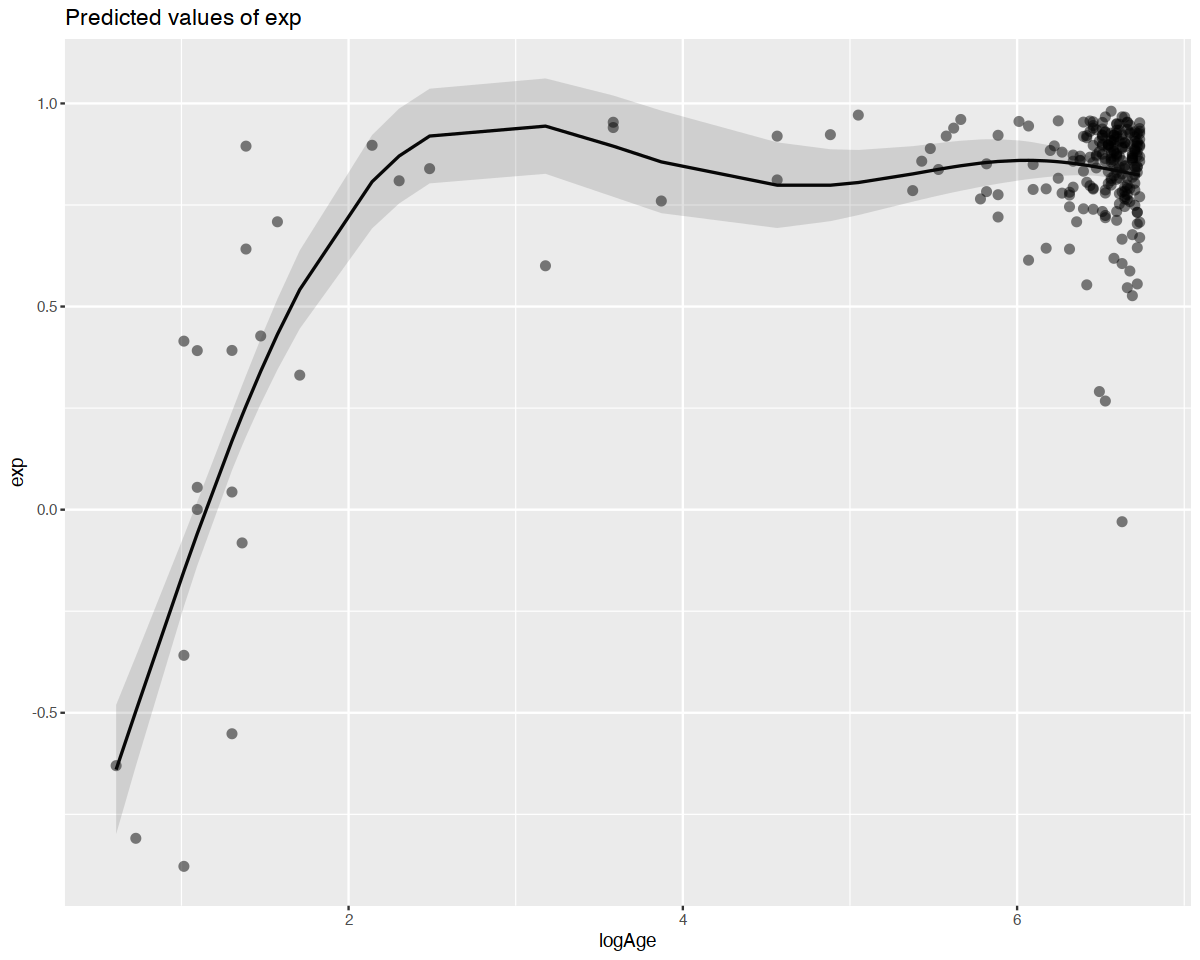

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]


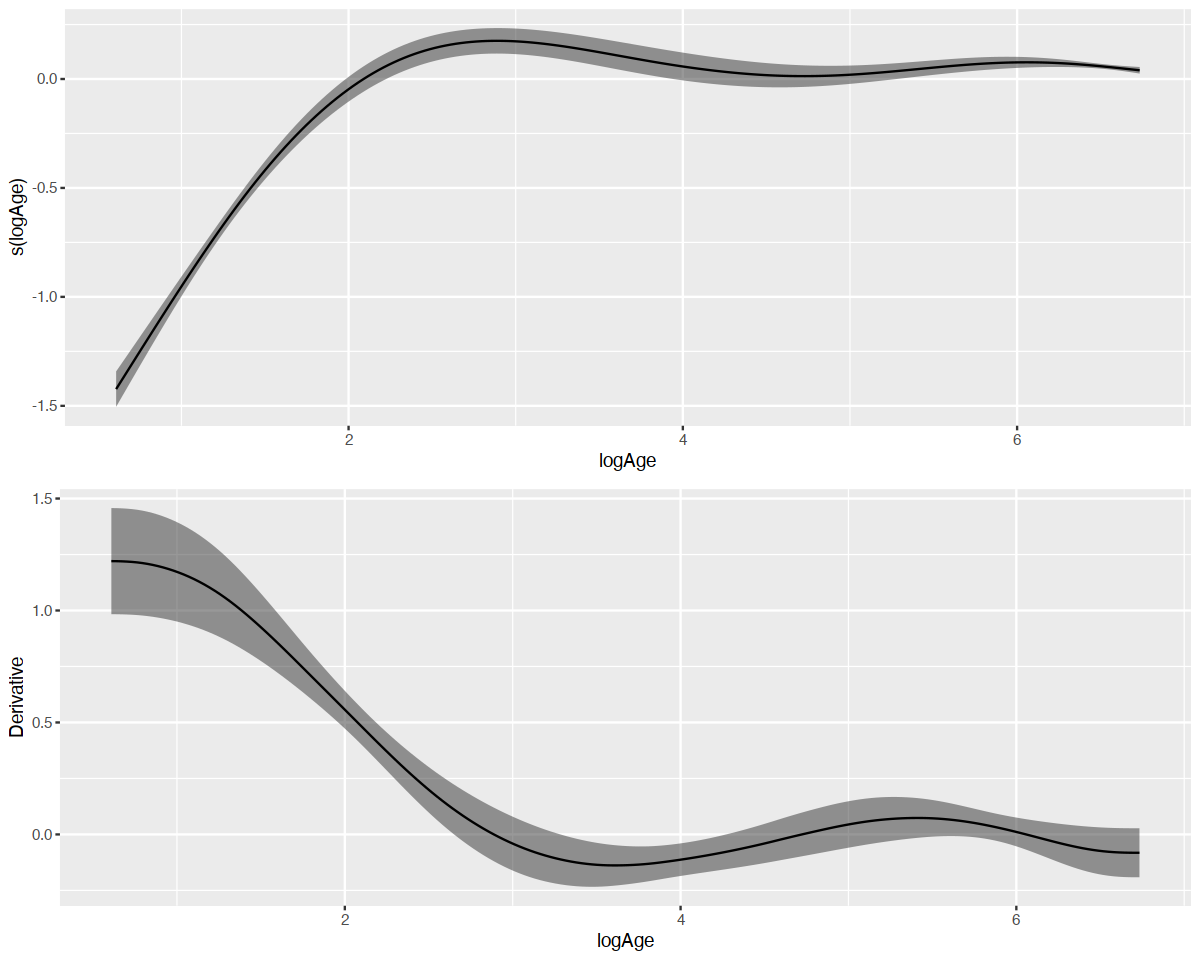

In [22]:
C1_df <- df_long %>%
  filter(component %in% c("C1_r"))
gam_model <- gam(exp ~ s(logAge,k=5),data = C1_df)

sjPlot::plot_model(gam_model,type = "pred",show.data = T)

gderv <- gam_derivatives(gam_model = gam_model,include_plot = TRUE,
                         smooth_term = "logAge")

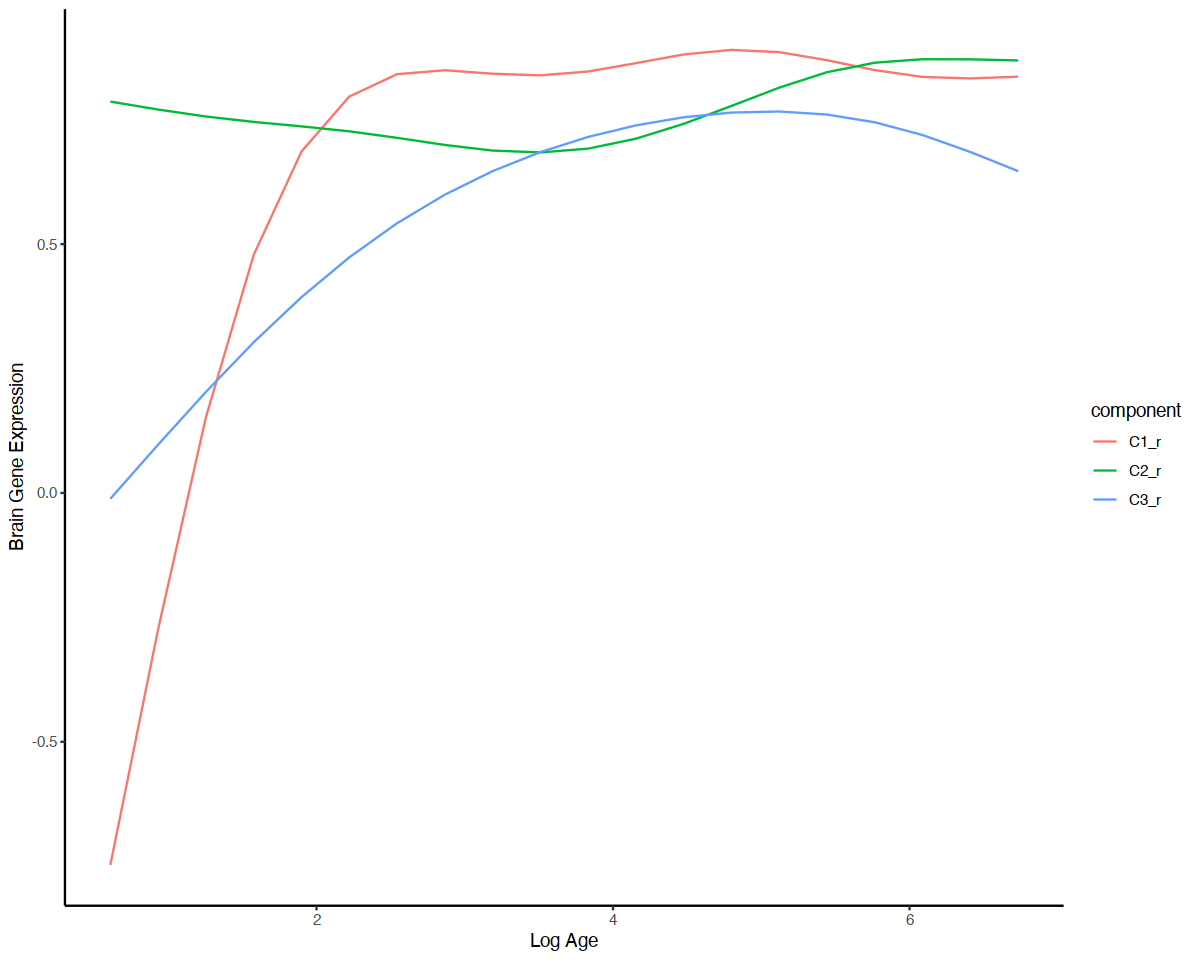

In [39]:
options(repr.plot.width=10, repr.plot.height=8)

plot_df <- gam_results %>%
  unnest(cols = c(derv,fit))

ggplot(data=plot_df,aes(x=fit.logAge,y=fit.est_adjusted,group=component))+
  geom_line(aes(color=component))+
  # scale_color_viridis(option = "inferno")+
  # geom_vline(xintercept = c(10*12,21*12))+
  theme_classic()+
  ylab("Brain Gene Expression")+xlab("Log Age")